## Práctica Machine Learning mIA-X
#### Clasificación de patrones técnicos

## Segunda Iteración

En esta parte se pide abordar el problema como una clasificacion multiclase para que se puedan reconocer
a la vez varias figuras tecnicas. Un esquema sencillo seria tener por ejemplo doble suelo, doble techo y
sin patron.

### Importamos librerias

In [ ]:
import numpy as np
import pandas as pd
import pickle
from datetime import datetime

import matplotlib.pyplot as plt

import sklearn

#### Cargamos la serie del IBEX 

In [ ]:
with open('benchmark_data.pkl', 'rb') as handle:
    bm = pickle.load(handle)

In [ ]:
ibex = bm['ibex']

In [ ]:
ibex.head()

,close,high,low,open,vol
2000-01-03,11610.0,11881.8,11574.4,11846.6,60107000.0
2000-01-04,11206.6,11530.0,11159.8,11499.5,62539000.0
2000-01-05,10863.1,11068.1,10824.9,11206.6,68153000.0
2000-01-07,11102.4,11137.9,10882.7,10963.4,144207000.0
2000-01-10,11173.3,11364.3,11120.6,11363.8,133817000.0


#### Lectura de ejemplos

In [ ]:
ejemplos = pd.read_csv('ejemplos_doble_suelo_techo_sin_patron.csv')
ejemplos.columns = ['fecha','etiqueta']

In [ ]:
ejemplos

,fecha,etiqueta
0,2010-04-14,1.0
1,2013-07-09,0.0
2,2015-11-03,0.0
3,2013-01-29,1.0
4,2006-03-08,1.0
...,...,...
226,2009-11-09,2.0
227,2006-08-04,0.0
228,2011-12-29,0.0
229,2016-05-10,0.0


Sacamos posición en la que se encuentra la fecha en el índice

In [ ]:
idx = ibex.index.get_loc(ejemplos.fecha.iloc[20])
idx

1070

In [ ]:
ibex.iloc[idx]

close         8390.1
high          8421.2
low           8307.8
open          8315.0
vol      110709000.0
Name: 2004-04-08 00:00:00, dtype: float64

Con el índice numérico reconstruimos la ventana

In [ ]:
window=30
windata = ibex.iloc[idx:idx+window]
windata.head()

,close,high,low,open,vol
2004-04-08,8390.1,8421.2,8307.8,8315.0,110709000.0
2004-04-13,8444.3,8478.0,8411.9,8414.6,118504000.0
2004-04-14,8352.0,8396.5,8278.3,8373.6,133910000.0
2004-04-15,8310.4,8370.4,8293.9,8352.6,106533000.0
2004-04-16,8387.9,8391.0,8315.0,8317.1,136929000.0


In [ ]:
windata.shape

(30, 5)

### Análisis exploratorio





In [ ]:
ejemplos.describe()

,etiqueta
count,231.000000
mean,0.454545
std,0.732099
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


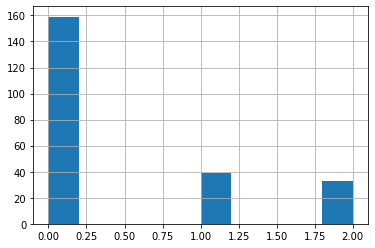

In [ ]:
ejemplos['etiqueta'].hist()

Tipología de las variables

In [ ]:
ejemplos.dtypes

fecha        object
etiqueta    float64
dtype: object

Comprobamos si hay NAs

In [ ]:
ejemplos.isna().any()

fecha       False
etiqueta    False
dtype: bool

### Ingeniería de Características

1. Retornos simples de la ventana

In [ ]:
def window_simple_returns(data):
    r = data.close.iloc[-1]/data.close.iloc[0] - 1
    return r 

In [ ]:
window_simple_returns(windata)

-0.06955816974767881

2. Retornos logaritmicos de la ventana

In [ ]:
def window_log_returns(data):
    r = np.log(data.close.iloc[-1])/np.log(data.close.iloc[0])
    return r 

In [ ]:
window_log_returns(windata)

0.9920202264832467

3. Numero de días que pasan entre el máximo y el mínimo de la ventana

In [ ]:
def days_between_max_min(data):
    
    maximum = data.high.max()
    minimum = data.low.min()
    days_between_max_min_index = abs(data[data.high == maximum].index - data[data.low == minimum].index)
    days_between_max_min = (days_between_max_min_index / np.timedelta64(1, 'D')).astype(int).tolist()[0]
    return days_between_max_min

In [ ]:
days_between_max_min(windata)

34

4. Si ocurre primero el máximo o el mínimo

In [ ]:
def first_max_min(data):
    
    maximum = data.high.max()
    minimum = data.low.min()
    maximum_date = data[data.high == maximum].index
    minimum_date = data[data.low == minimum].index
    if maximum_date < minimum_date:
        first_max = 1
    else:
        first_max = 0
    
    return first_max

In [ ]:
first_max_min(windata)

1

5. Numero de veces en la ventana que se llega cerca del mínimo

In [ ]:
def treshold_min(data):
    minimum = data.low.min()
    th = 1.02
    df = data[data['low'] < th*minimum]
    df.shape[0]
             
    n = df.shape[0]*100/100
    
    return n

In [ ]:
treshold_min(windata)

3.0

6. Numero de veces en la ventana que se llega cerca del máximo

In [ ]:
def treshold_max(data):
    maximum = data.high.max()
    th = 0.99
    df= data[data['high'] > th*maximum]
    df.shape[0]
             
    n = df.shape[0]*100/100
    
    return n

In [ ]:
treshold_max(windata)

6.0

### Preprocesamiento de los datos

Inclusión de features en ejemplos

In [ ]:
ejemplos['feature1'] = np.zeros(len(ejemplos))
ejemplos['feature2'] = np.zeros(len(ejemplos))
ejemplos['feature3'] = np.zeros(len(ejemplos))
ejemplos['feature4'] = np.zeros(len(ejemplos))
ejemplos['feature5'] = np.zeros(len(ejemplos))
ejemplos['feature6'] = np.zeros(len(ejemplos))

In [ ]:
ejemplos.head()

,fecha,etiqueta,feature1,feature2,feature3,feature4,feature5,feature6
0,2010-04-14,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-07-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-11-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-01-29,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2006-03-08,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ejemplos.shape[0]

231

In [ ]:
len(ejemplos)

231

In [ ]:
for i in range(len(ejemplos)):
    
    idx = ibex.index.get_loc(ejemplos.fecha.iloc[i])
    windata = ibex.iloc[idx:idx+window]
    
    ejemplos.feature1[i] = window_simple_returns(windata)
    ejemplos.feature2[i] = window_log_returns(windata)
    ejemplos.feature3[i] = days_between_max_min(windata)
    ejemplos.feature4[i] = first_max_min(windata)
    ejemplos.feature5[i] = treshold_min(windata)
    ejemplos.feature6[i] = treshold_max(windata)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarn

In [ ]:
ejemplos.head()

,fecha,etiqueta,feature1,feature2,feature3,feature4,feature5,feature6
0,2010-04-14,1.0,-0.217261,0.973803,41.0,1.0,2.0,3.0
1,2013-07-09,0.0,0.080139,1.008576,30.0,0.0,5.0,7.0
2,2015-11-03,0.0,-0.099062,0.988729,40.0,1.0,2.0,2.0
3,2013-01-29,1.0,-0.010251,0.998863,7.0,1.0,11.0,4.0
4,2006-03-08,1.0,0.013191,1.001400,26.0,1.0,14.0,18.0


Preprocesamos los datos para conseguir un conjunto de entrenamiento de calidad

In [ ]:
def preprocesamiento(df):
  
    # Eliminar columnas con NAs
    df = df.dropna()
    
    # Cambiar orden de columnas
    df = df[['fecha', 'feature1', 'feature2', 'feature3','feature4','feature5','feature6', 'etiqueta']]
    
    # Eliminar características basadas en texto
    features_to_drop = ["fecha"]
    df = df.drop(features_to_drop, axis=1)
    

    return df

In [ ]:
ejemplos = preprocesamiento(ejemplos)
ejemplos.head()

,feature1,feature2,feature3,feature4,feature5,feature6,etiqueta
0,-0.217261,0.973803,41.0,1.0,2.0,3.0,1.0
1,0.080139,1.008576,30.0,0.0,5.0,7.0,0.0
2,-0.099062,0.988729,40.0,1.0,2.0,2.0,0.0
3,-0.010251,0.998863,7.0,1.0,11.0,4.0,1.0
4,0.013191,1.001400,26.0,1.0,14.0,18.0,1.0


### Análisis exploratorio tras la inclusión de las características

Análisis estadístico de las variables

In [ ]:
ejemplos.describe()

,feature1,feature2,feature3,feature4,feature5,feature6,etiqueta
count,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000
mean,0.014147,1.001221,26.580087,0.419913,5.679654,5.160173,0.454545
std,0.080059,0.008880,10.258034,0.494616,4.281555,3.049643,0.732099
min,-0.233581,0.971384,6.000000,0.000000,1.000000,1.000000,0.000000
25%,-0.036294,0.995922,18.000000,0.000000,3.000000,3.000000,0.000000
50%,0.025197,1.002689,27.000000,0.000000,5.000000,5.000000,0.000000
75%,0.065454,1.007027,35.000000,1.000000,8.000000,7.000000,1.000000
max,0.256786,1.025841,52.000000,1.000000,24.000000,18.000000,2.000000


Tipología de las variables

In [ ]:
ejemplos.dtypes

feature1    float64
feature2    float64
feature3    float64
feature4    float64
feature5    float64
feature6    float64
etiqueta    float64
dtype: object

Comprobamos si hay NAs

In [ ]:
ejemplos.isna().any()

feature1    False
feature2    False
feature3    False
feature4    False
feature5    False
feature6    False
etiqueta    False
dtype: bool

### Estandarización de variables
Estandarizar las variables siempre es una buena practica.

In [ ]:
from sklearn.preprocessing import StandardScaler

Separamos nuestra variable objetivo del conjunto de datos para realizar la estandarización

In [ ]:
features = ejemplos.loc[:, ejemplos.columns !='etiqueta']
target = ejemplos.etiqueta

Estandarizamos los datos con una media = 0  y desviación típica = 1

In [ ]:
scaler = StandardScaler()
features[['feature1', 'feature2','feature3','feature4','feature5','feature6']] = scaler.fit_transform(features[['feature1', 'feature2','feature3','feature4','feature5','feature6']])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [ ]:
features.describe().round(decimals=3)

,feature1,feature2,feature3,feature4,feature5,feature6
count,231.000,231.000,231.000,231.000,231.000,231.000
mean,-0.000,0.000,0.000,0.000,-0.000,-0.000
std,1.002,1.002,1.002,1.002,1.002,1.002
min,-3.101,-3.367,-2.011,-0.851,-1.095,-1.367
25%,-0.631,-0.598,-0.838,-0.851,-0.627,-0.710
50%,0.138,0.166,0.041,-0.851,-0.159,-0.053
75%,0.642,0.655,0.823,1.175,0.543,0.605
max,3.037,2.779,2.483,1.175,4.288,4.219


In [ ]:
target.value_counts()

0.0    159
1.0     39
2.0     33
Name: etiqueta, dtype: int64

In [ ]:
target.value_counts()/target.shape[0]

0.0    0.688312
1.0    0.168831
2.0    0.142857
Name: etiqueta, dtype: float64

## Árbol de decisión, KNN, Naive Bayes

Utilizaremos un árbol de decisión, un K-NN y un Naive-Bayes para realizar la clasificación de los patrones de doble suelo, doble techo y sin patrón.

#### Separación del conjunto en train/test

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features.values,
                                                    target.values,
                                                    test_size=0.3,
                                                    stratify=target)

#### Inicializamos el modelo

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
Tree = DecisionTreeClassifier(max_depth=5)
KNN = KNeighborsClassifier()
NBayes = GaussianNB()

#### Entrenamos el modelo

In [ ]:
Tree = Tree.fit(x_train, y_train)
KNN = KNN.fit(x_train, y_train)
NBayes = NBayes.fit(x_train, y_train)

In [ ]:
print(Tree.classes_)

[0. 1. 2.]


In [ ]:
print(KNN.classes_)

[0. 1. 2.]


In [ ]:
print(NBayes.classes_)

[0. 1. 2.]


Calculamos las predicciones

In [ ]:
Tree_pred = Tree.predict(x_test)
KNN_pred = KNN.predict(x_test)
NBayes_pred = NBayes.predict(x_test)

In [ ]:
Tree_pred.shape

(70,)

In [ ]:
KNN_pred.shape

(70,)

In [ ]:
NBayes_pred.shape

(70,)

In [ ]:
all_pred = pd.DataFrame({
    'Tree':Tree_pred,
    'KNN':KNN_pred,
    'NBayes':NBayes_pred
})

- Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
print('Tree',accuracy_score(y_test,Tree_pred))
print('KNN',accuracy_score(y_test,KNN_pred))
print('NBayes',accuracy_score(y_test,NBayes_pred))

Tree 0.6857142857142857
KNN 0.7285714285714285
NBayes 0.6428571428571429


In [ ]:
from sklearn.model_selection import cross_validate

#### Evaluamos el modelo

- Validación cruzada

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
scoring = ['accuracy']

Árbol de decisión

In [ ]:
Tree_scores = cross_validate(Tree, features, target, scoring=scoring, cv=4)
pd.DataFrame(Tree_scores).mean()

fit_time         0.002671
score_time       0.001176
test_accuracy    0.706518
dtype: float64

KNN

In [ ]:
KNN_scores = cross_validate(KNN, features, target, scoring=scoring, cv=4)
pd.DataFrame(KNN_scores).mean()

fit_time         0.001974
score_time       0.003108
test_accuracy    0.727754
dtype: float64

NBayes

In [ ]:
NBayes_scores = cross_validate(NBayes, features, target, scoring=scoring, cv=4)
pd.DataFrame(NBayes_scores).mean()

fit_time         0.002433
score_time       0.001423
test_accuracy    0.744857
dtype: float64

El modelo con mayor accuracy es el NBayes

### Evaluación del mejor modelo sobre un conjunto de test por separado

#### Lectura del nuevo conjunto de test

In [ ]:
conjunto_test = pd.read_csv('ejemplos_doble_suelo_techo_sin_patron_2.csv')
conjunto_test.columns = ['fecha','etiqueta']
conjunto_test

,fecha,etiqueta
0,2001-12-12,2.0
1,2014-09-18,0.0
2,2001-09-19,0.0
3,2012-03-15,0.0
4,2005-01-12,1.0
...,...,...
93,2008-10-14,1.0
94,2004-03-05,1.0
95,2004-12-10,2.0
96,2015-06-16,2.0


### Preprocesamiento de los datos

Inclusión de features en ejemplos

In [ ]:
conjunto_test['feature1'] = np.zeros(len(conjunto_test))
conjunto_test['feature2'] = np.zeros(len(conjunto_test))
conjunto_test['feature3'] = np.zeros(len(conjunto_test))
conjunto_test['feature4'] = np.zeros(len(conjunto_test))
conjunto_test['feature5'] = np.zeros(len(conjunto_test))
conjunto_test['feature6'] = np.zeros(len(conjunto_test))

In [ ]:
conjunto_test.head()

,fecha,etiqueta,feature1,feature2,feature3,feature4,feature5,feature6
0,2001-12-12,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014-09-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2001-09-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012-03-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2005-01-12,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for i in range(len(conjunto_test)):
    
    idx = ibex.index.get_loc(conjunto_test.fecha.iloc[i])
    windata = ibex.iloc[idx:idx+window]
    
    conjunto_test.feature1[i] = window_simple_returns(windata)
    conjunto_test.feature2[i] = window_log_returns(windata)
    conjunto_test.feature3[i] = days_between_max_min(windata)
    conjunto_test.feature4[i] = first_max_min(windata)
    conjunto_test.feature5[i] = treshold_min(windata)
    conjunto_test.feature6[i] = treshold_max(windata)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarn

In [ ]:
conjunto_test.head()

,fecha,etiqueta,feature1,feature2,feature3,feature4,feature5,feature6
0,2001-12-12,2.0,-0.041500,0.995317,34.0,1.0,7.0,1.0
1,2014-09-18,0.0,-0.067619,0.992476,27.0,1.0,1.0,1.0
2,2001-09-19,0.0,0.121250,1.012940,34.0,0.0,1.0,2.0
3,2012-03-15,0.0,-0.152005,0.981759,33.0,1.0,5.0,3.0
4,2005-01-12,1.0,0.045228,1.004862,22.0,0.0,11.0,7.0


Preprocesamos los datos para conseguir un conjunto de entrenamiento de calidad

In [ ]:
def preprocesamiento(df):
  
    # Eliminar columnas con NAs
    df = df.dropna()
    
    # Cambiar orden de columnas
    df = df[['fecha', 'feature1', 'feature2', 'feature3','feature4','feature5','feature6', 'etiqueta']]
    
    # Eliminar características basadas en texto
    features_to_drop = ["fecha"]
    df = df.drop(features_to_drop, axis=1)
    

    return df

In [ ]:
conjunto_test = preprocesamiento(conjunto_test)
conjunto_test.head()

,feature1,feature2,feature3,feature4,feature5,feature6,etiqueta
0,-0.041500,0.995317,34.0,1.0,7.0,1.0,2.0
1,-0.067619,0.992476,27.0,1.0,1.0,1.0,0.0
2,0.121250,1.012940,34.0,0.0,1.0,2.0,0.0
3,-0.152005,0.981759,33.0,1.0,5.0,3.0,0.0
4,0.045228,1.004862,22.0,0.0,11.0,7.0,1.0


### Estandarización de variables
Estandarizar las variables siempre es una buena practica.

In [ ]:
from sklearn.preprocessing import StandardScaler

Separamos nuestra variable objetivo del conjunto de datos para realizar la estandarización

In [ ]:
features_test = conjunto_test.loc[:, conjunto_test.columns !='etiqueta']
target_test = conjunto_test.etiqueta

Estandarizamos los datos con una media = 0  y desviación típica = 1

In [ ]:
scaler = StandardScaler()
features_test[['feature1', 'feature2','feature3','feature4','feature5','feature6']] = scaler.fit_transform(features_test[['feature1', 'feature2','feature3','feature4','feature5','feature6']])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [ ]:
features_test

,feature1,feature2,feature3,feature4,feature5,feature6
0,-0.472048,-0.433332,0.776113,1.041684,0.279996,-1.229445
1,-0.801757,-0.750104,0.038698,1.041684,-1.258675,-1.229445
2,1.582417,1.531085,0.776113,-0.959984,-1.258675,-0.938417
3,-1.866997,-1.944645,0.670768,1.041684,-0.232894,-0.647389
4,0.622763,0.630571,-0.488026,-0.959984,1.305777,0.516723
...,...,...,...,...,...,...
93,-1.925920,-1.968699,-1.436131,1.041684,-0.489339,-1.229445
94,0.043204,0.080213,0.144043,-0.959984,0.536442,-0.356361
95,0.346418,0.371675,-0.277337,-0.959984,2.331558,1.680836
96,0.369983,0.387192,-1.541476,-0.959984,-0.489339,0.516723


In [ ]:
features_test.describe().round(decimals=3)

,feature1,feature2,feature3,feature4,feature5,feature6
count,98.000,98.000,98.000,98.000,98.000,98.000
mean,-0.000,0.000,0.000,0.000,0.000,0.000
std,1.005,1.005,1.005,1.005,1.005,1.005
min,-2.190,-2.393,-2.384,-0.960,-1.259,-1.229
25%,-0.688,-0.658,-0.699,-0.960,-0.746,-0.647
50%,0.144,0.178,0.144,-0.960,-0.233,-0.065
75%,0.716,0.720,0.776,1.042,0.536,0.517
max,2.302,2.132,1.724,1.042,4.127,4.882


In [ ]:
target_test.value_counts()

0.0    65
1.0    19
2.0    14
Name: etiqueta, dtype: int64

In [ ]:
target_test.value_counts()/target.shape[0]

0.0    0.281385
1.0    0.082251
2.0    0.060606
Name: etiqueta, dtype: float64

#### Evaluamos el mejor modelo 

Calculamos las predicciones

In [ ]:
NBayes_conjunto_test_pred = NBayes.predict(features_test)

In [ ]:
NBayes_conjunto_test_pred.shape

(98,)

- Accuracy (Precisión global)

In [ ]:
print('NBayes:', accuracy_score(target_test, NBayes_conjunto_test_pred))

NBayes: 0.6020408163265306


- Precision (Precisión de clase)

In [ ]:
from sklearn.metrics import precision_score

Micro average

In [ ]:
print('micro average:', precision_score(target_test, NBayes_conjunto_test_pred, average='micro'))

micro average: 0.6020408163265306


Macro average

In [ ]:
print('macro average:', precision_score(target_test, NBayes_conjunto_test_pred, average='macro'))

macro average: 0.5068627450980392


- Recall (Sensibilidad)

In [ ]:
from sklearn.metrics import recall_score

Micro average

In [ ]:
print('micro average:', recall_score(target_test, NBayes_conjunto_test_pred, average='micro'))

micro average: 0.6020408163265306


Macro average

In [ ]:
print('macro average:', recall_score(target_test, NBayes_conjunto_test_pred, average='macro'))

macro average: 0.45178330441488335
